## Notebook setup

In [1]:
import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import warnings, scipy.sparse as sp, matplotlib, matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import rc_context
import matplotlib.font_manager

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rc('font', size=14)

pd.set_option('display.max_rows', 200)

sc.set_figure_params(dpi=80, dpi_save=300, color_map='Spectral_r', vector_friendly=True, transparent=True)
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.2 scipy==1.5.3 pandas==1.3.5 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [2]:
%matplotlib inline 

In [3]:
# preset color palettes and color maps
user_defined_palette =  [ '#F6222E', '#16FF32', '#3283FE', '#FEAF16', '#BDCDFF', '#3B00FB', '#1CFFCE', '#C075A6', '#F8A19F', '#B5EFB5', '#FBE426', '#C4451C', 
                          '#2ED9FF', '#c1c119', '#8b0000', '#FE00FA', '#1CBE4F', '#1C8356', '#0e452b', '#AA0DFE', '#B5EFB5', '#325A9B', '#90AD1C']

user_defined_cmap_markers = LinearSegmentedColormap.from_list('mycmap', ["#E6E6FF", "#CCCCFF", "#B2B2FF", "#9999FF",  "#6666FF",   "#3333FF", "#0000FF"])
user_defined_cmap_degs = LinearSegmentedColormap.from_list('mycmap', ["#0000FF", "#3333FF", "#6666FF", "#9999FF", "#B2B2FF", "#CCCCFF", "#E6E6FF", "#E6FFE6", "#CCFFCC", "#B2FFB2", "#99FF99", "#66FF66", "#33FF33", "#00FF00"])

## Perform quality control and clean-up samples

### Load cellranger output files

In [4]:
from pathlib import Path

adatas_list=[]
names_list=[]

tenexdir = '../../data/internal/NucSeq'
h5_path = Path(tenexdir).glob('**/**/**/filtered_feature_bc_matrix.h5')

for path in h5_path:
    tmp_adata = sc.read_10x_h5(path)
    tmp_adata.var_names_make_unique()
    tmp_adata.shape # check the number of cells and genes in sample 1
    adatas_list.append(tmp_adata)

reading ../../data/internal/NucSeq/SD-1680_Patient_F_nucseq_GE/cr-gex-results/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
reading ../../data/internal/NucSeq/SD-1680_Patient_D_nucseq_2_GE/cr-gex-results/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
reading ../../data/internal/NucSeq/SD-1680_Patient_F_nucseq_2_GE/cr-gex-results/outs/filtered_feature_bc_matrix.h5


/Users/akousa/opt/anaconda3/envs/shunPykeR/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading ../../data/internal/NucSeq/SD-1680_Patient_I_nucseq_GE/cr-gex-results/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
reading ../../data/internal/NucSeq/SD-1680_Patient_D_nucseq_GE/cr-gex-results/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
reading ../../data/internal/NucSeq/SD-1680_Patient_I_nucseq_2_GE/cr-gex-results/outs/filtered_feature_bc_matrix.h5
 (0:00:00)


In [5]:
adata = sc.concat(
    adatas_list, # add more annadata objects here separated by commas
    join='outer', 
    label = 'sample', 
    keys = ['Patient_F', 'Patient_D_2', 'Patient_F_2', 'Patient_I', 'Patient_D', 'Patient_I_2',], # or use your sample_names list (as used above) here. 
    # Make sure the order of the batch categories matches that of the AnnData objects 
    index_unique = '@'
)

In [6]:
adata.raw = adata # keep a copy of the raw adata 
np.random.seed(42) 
index_list = np.arange(adata.shape[0]) # randomize the order of cells for plotting
np.random.shuffle(index_list)
adata = adata[index_list]

In [7]:
adata.shape

(5847, 36601)

### Calculate quality control metrics

In [8]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata.obs['original_total_counts'] = adata.obs['total_counts']
adata.obs['log10_original_total_counts'] = np.log10(adata.obs['original_total_counts'])

/Users/akousa/opt/anaconda3/envs/shunPykeR/lib/python3.8/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


#### Identify doublet cells

In [9]:
sc.external.pp.scrublet(adata, threshold=0.05, random_state=42) # choose threshold manually

Running Scrublet
filtered out 7576 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/akousa/opt/anaconda3/envs/shunPykeR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Detected doublet rate = 41.2%
Estimated detectable doublet fraction = 87.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 46.9%
    Scrublet finished (0:00:06)


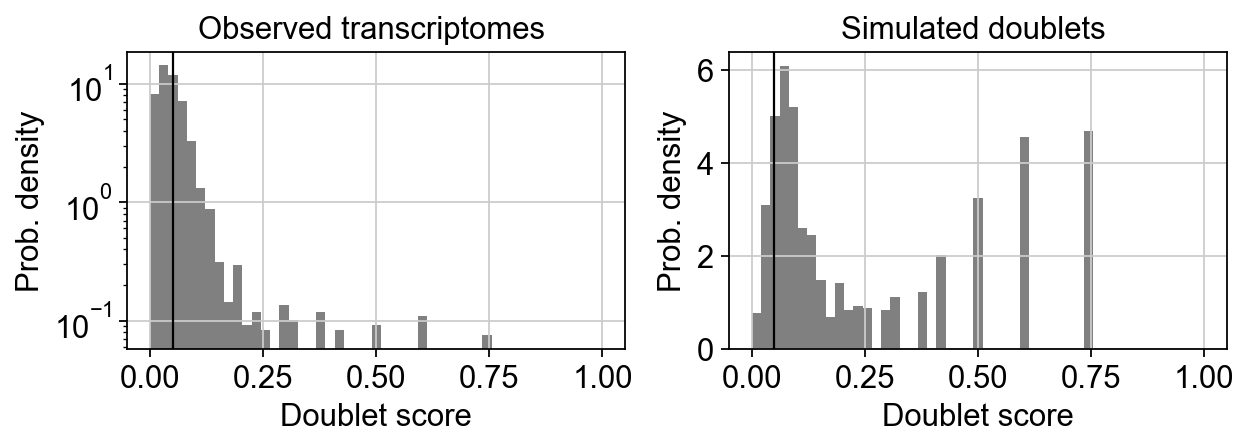

In [10]:
sc.external.pl.scrublet_score_distribution(adata)

In [11]:
adata = adata[adata.obs['predicted_doublet'] == False]

#### Remove not expressed genes

In [12]:
sc.pp.filter_genes(adata, min_cells=1)

filtered out 5740 genes that are detected in less than 1 cells


/Users/akousa/opt/anaconda3/envs/shunPykeR/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


#### Normalize for each cell's library size

In [13]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10**4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


#### Log-transform counts

In [14]:
sc.pp.log1p(adata)

### Select subset of principal components 

In [15]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, n_bins=20, flavor='seurat',  inplace=True)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [16]:
rng = np.random.RandomState(42)
sc.tl.pca(adata, n_comps=200, svd_solver='arpack', random_state=rng)

computing PCA
    on highly variable genes
    with n_comps=200
    finished (0:00:00)


<function matplotlib.pyplot.show(close=None, block=None)>

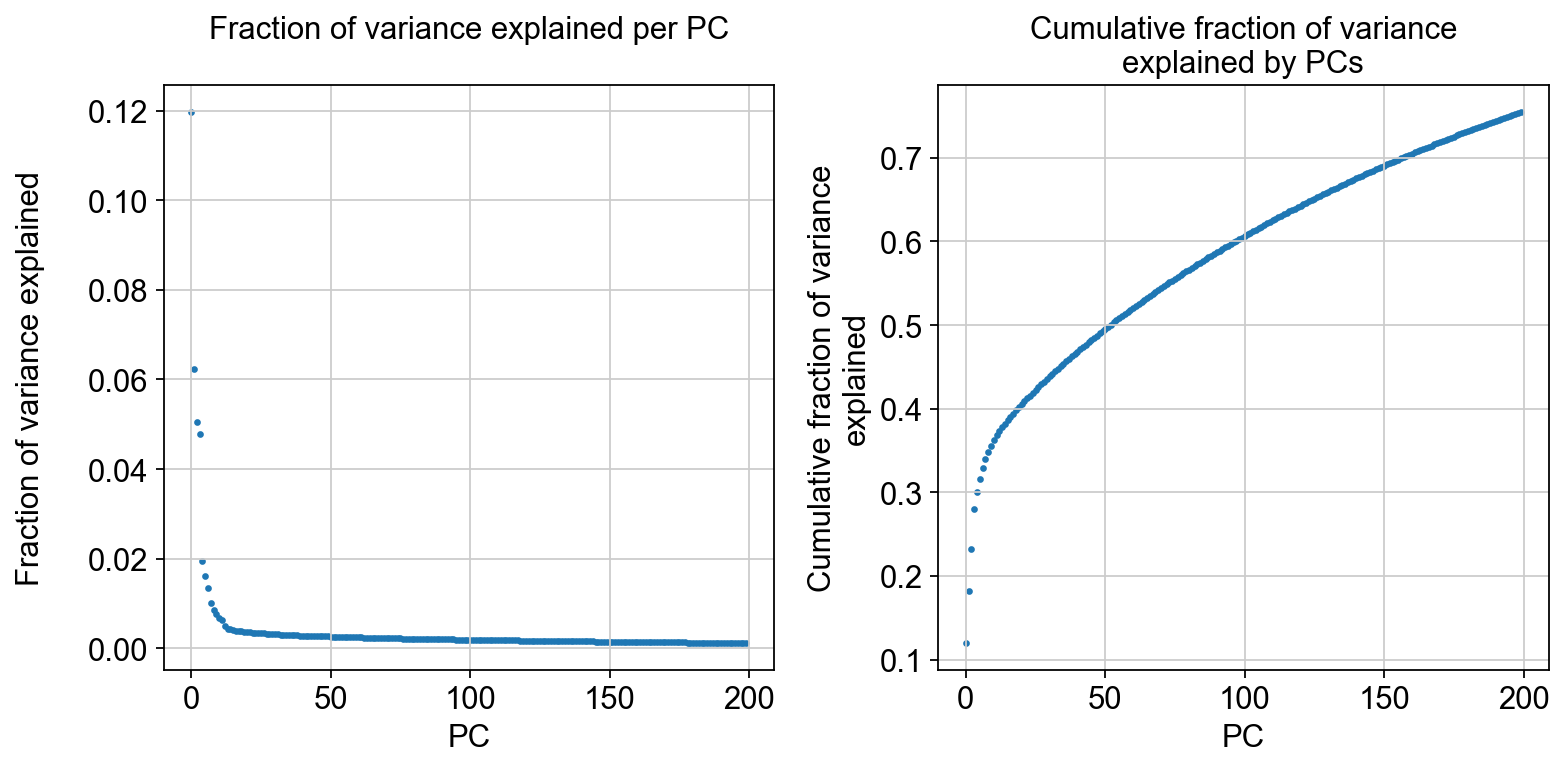

In [17]:
def observe_variance(anndata_object):
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    # variance per principal component
    x = range(len(anndata_object.uns['pca']['variance_ratio']))
    y = anndata_object.uns['pca']['variance_ratio']
    ax1.scatter(x,y,s=4)
    ax1.set_xlabel('PC')
    ax1.set_ylabel('Fraction of variance explained\n')
    ax1.set_title('Fraction of variance explained per PC\n')
    # cumulative variance explained
    cml_var_explained = np.cumsum(anndata_object.uns['pca']['variance_ratio'])
    x = range(len(anndata_object.uns['pca']['variance_ratio']))
    y = cml_var_explained
    ax2.scatter(x,y,s=4)
    ax2.set_xlabel('PC')
    ax2.set_ylabel('Cumulative fraction of variance\nexplained')
    ax2.set_title('Cumulative fraction of variance\nexplained by PCs')
    fig.tight_layout()
    plot = plt.show
    return(plot)
observe_variance(adata)

In [18]:
rng = np.random.RandomState(42)
sc.tl.pca(adata, n_comps=30,  svd_solver='arpack', random_state=rng)

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


## Correct for batch effects with harmony (optional)

In [19]:
sce.pp.harmony_integrate(adata, 'sample')

2023-01-11 12:09:03,659 - harmonypy - INFO - Iteration 1 of 10
2023-01-11 12:09:04,113 - harmonypy - INFO - Iteration 2 of 10
2023-01-11 12:09:04,548 - harmonypy - INFO - Iteration 3 of 10
2023-01-11 12:09:04,897 - harmonypy - INFO - Iteration 4 of 10
2023-01-11 12:09:05,326 - harmonypy - INFO - Iteration 5 of 10
2023-01-11 12:09:05,710 - harmonypy - INFO - Iteration 6 of 10
2023-01-11 12:09:05,944 - harmonypy - INFO - Converged after 6 iterations


In [20]:
rng = np.random.RandomState(42)

In [21]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_pca_harmony')
sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


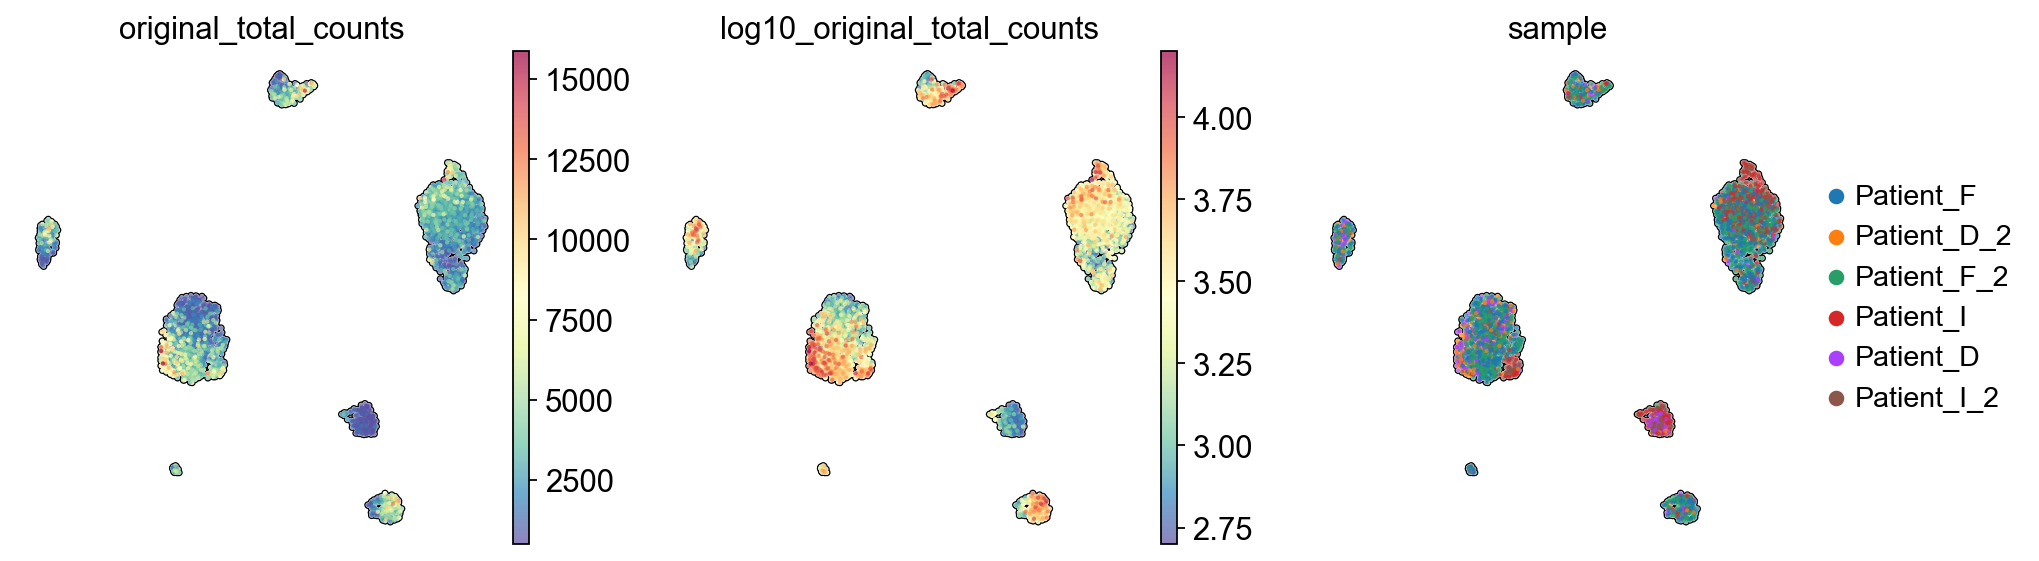

In [22]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=True, transparent=True)

sc.pl.umap(adata,
               color=['original_total_counts', 'log10_original_total_counts', 'sample'],
               use_raw=False,
               frameon=False, 
               color_map='Spectral_r',
               size=15,
               add_outline=True,
               wspace = 0.2,
               ncols = 4
              )

### Rerun leiden clustering after harmony correction

In [23]:
for resolution_parameter in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    sc.tl.leiden(adata,  resolution=resolution_parameter, random_state=42, 
                        key_added='leiden_'+str(resolution_parameter))

running Leiden clustering
    finished: found 7 clusters and added
    'leiden_0.1', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_0.2', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_0.3', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_0.4', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_0.6', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_0.7', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering


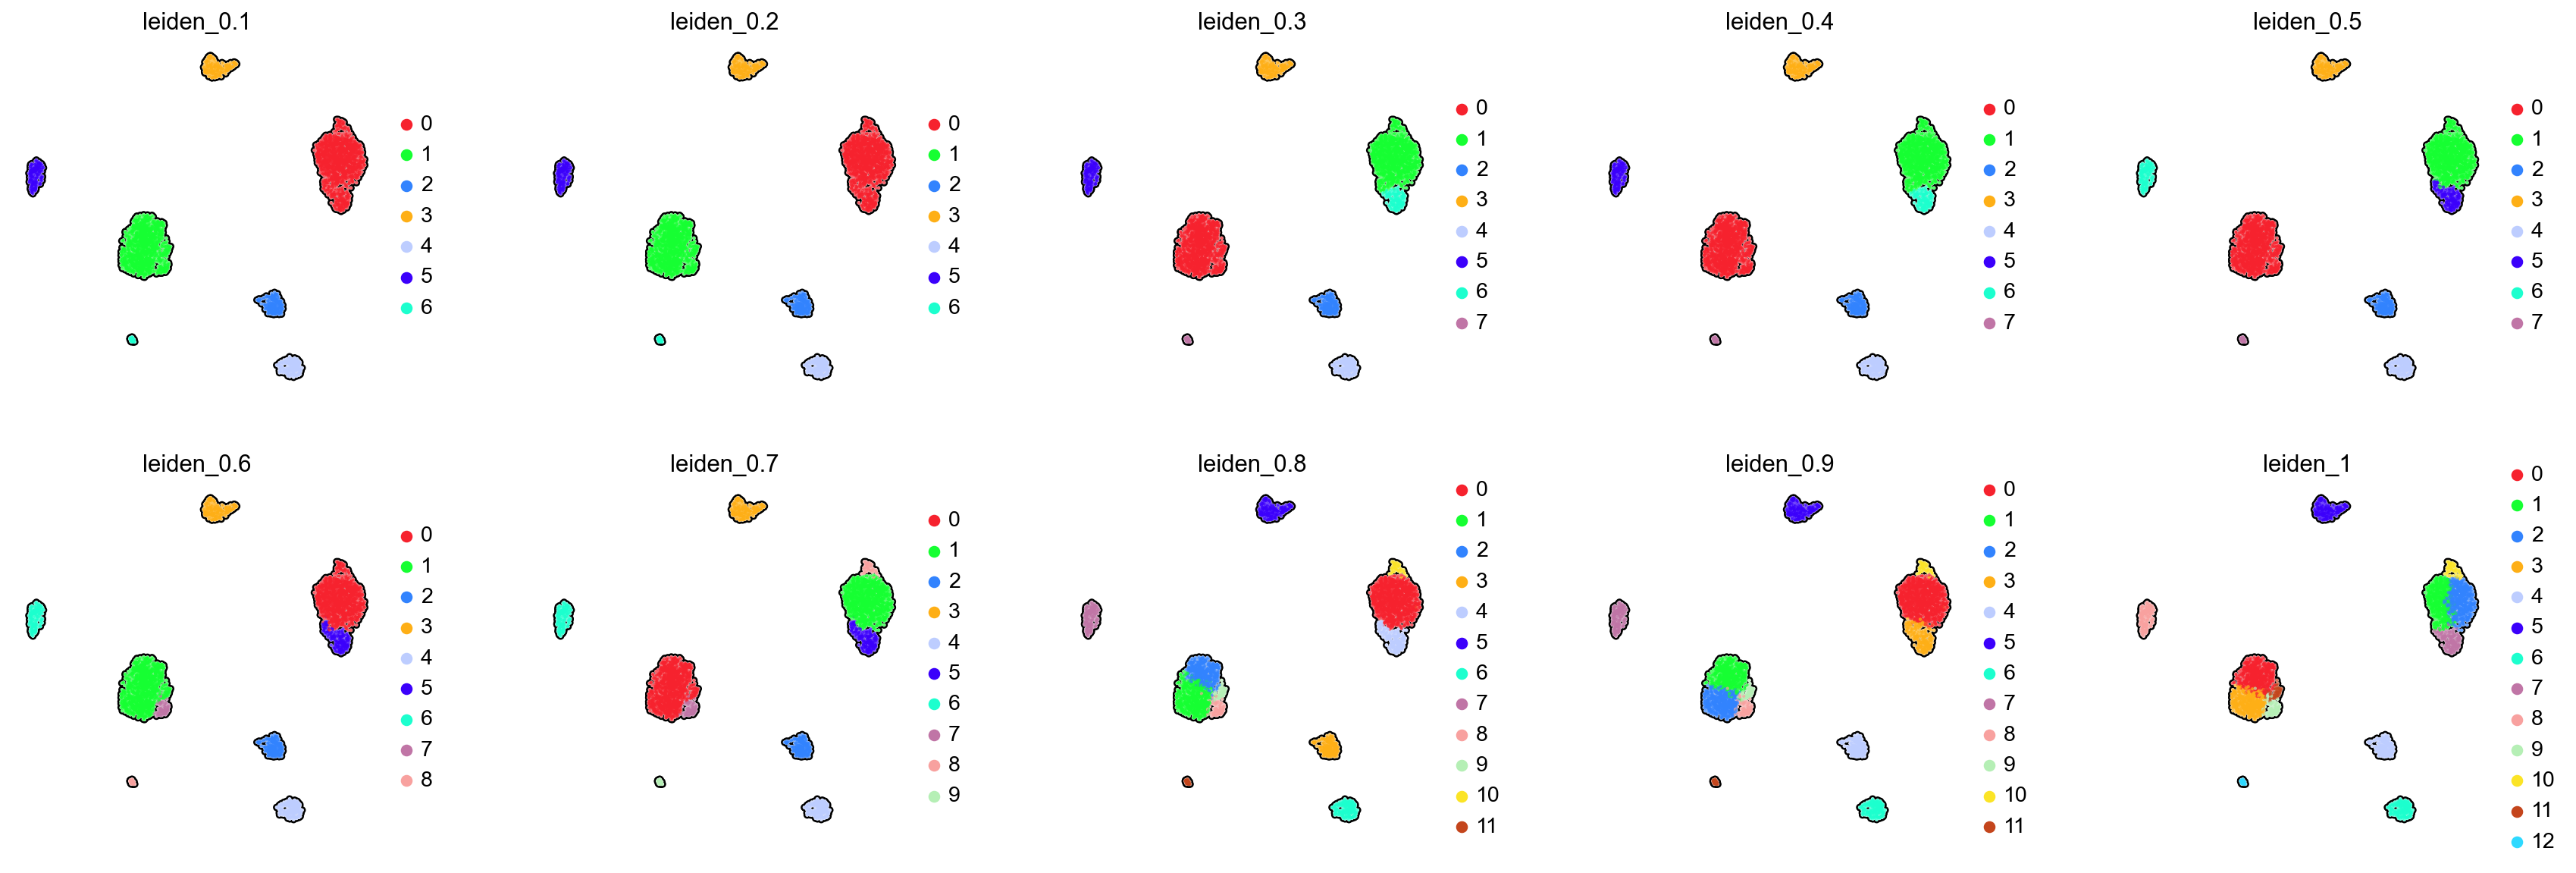

In [24]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
sc.pl.umap(
    adata, 
    color=['leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 
           'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'leiden_1'], 
    palette=user_defined_palette,  
    color_map='Spectral_r',
    use_raw=False,
    ncols=5,
    wspace = 0.3,
    outline_width=[0.6, 0.05],
    size=15,
    frameon=False,
    add_outline=True,
    sort_order = False
)

In [25]:
sc.tl.leiden(adata, resolution=0.1, random_state=42, key_added='leiden_0.1')

running Leiden clustering
    finished: found 7 clusters and added
    'leiden_0.1', the cluster labels (adata.obs, categorical) (0:00:00)


In [26]:
sc.tl.rank_genes_groups(adata, 'leiden_0.1', method='wilcoxon', use_raw=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


In [27]:
# top 5 differentially expressed genes for each cell type. Change number in brackets to get a more extended gene list
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores', 'pvals_adj']}).head(5)

,0_n,0_s,0_p,1_n,1_s,1_p,2_n,2_s,2_p,3_n,...,3_p,4_n,4_s,4_p,5_n,5_s,5_p,6_n,6_s,6_p
0,PID1,48.071678,0.0,SORBS1,47.351078,0.0,CSMD1,16.852114,3.471182e-60,NRXN3,...,1.036201e-110,ANO1,22.645514,2.589085e-109,RBPJ,20.676260,1.748851e-90,VWF,9.588902,2.747477e-17
1,LAMA2,43.762650,0.0,MYH11,46.956810,0.0,MTRNR2L12,14.340463,1.221309e-43,CADM2,...,1.592787e-108,SGCZ,22.641865,2.589085e-109,CD163,20.506767,2.890684e-89,ANO2,9.263326,3.057740e-16
2,PDGFRA,43.751110,0.0,SVIL,46.801208,0.0,FP671120.4,13.753188,3.856331e-40,NRXN1,...,5.407117e-106,OBSCN,22.154907,9.623919e-105,SLC1A3,19.293161,6.306666e-79,ABLIM1,9.092870,9.922739e-16
3,TSHZ2,43.174725,0.0,CACNA1C,46.639240,0.0,RBFOX1,13.588948,3.422088e-39,PPP2R2B,...,6.130811e-106,KIT,22.065586,5.222186e-104,F13A1,19.249273,1.104483e-78,SEC14L1,8.777605,1.288388e-14
4,EBF1,43.146992,0.0,PRUNE2,46.138939,0.0,FP236383.3,10.156913,6.480743e-22,ANK3,...,8.660174e-106,KCNIP4,21.970436,3.409318e-103,FMN1,18.758251,1.023144e-74,FLT1,8.646723,3.271248e-14


    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_leiden_0.1']`


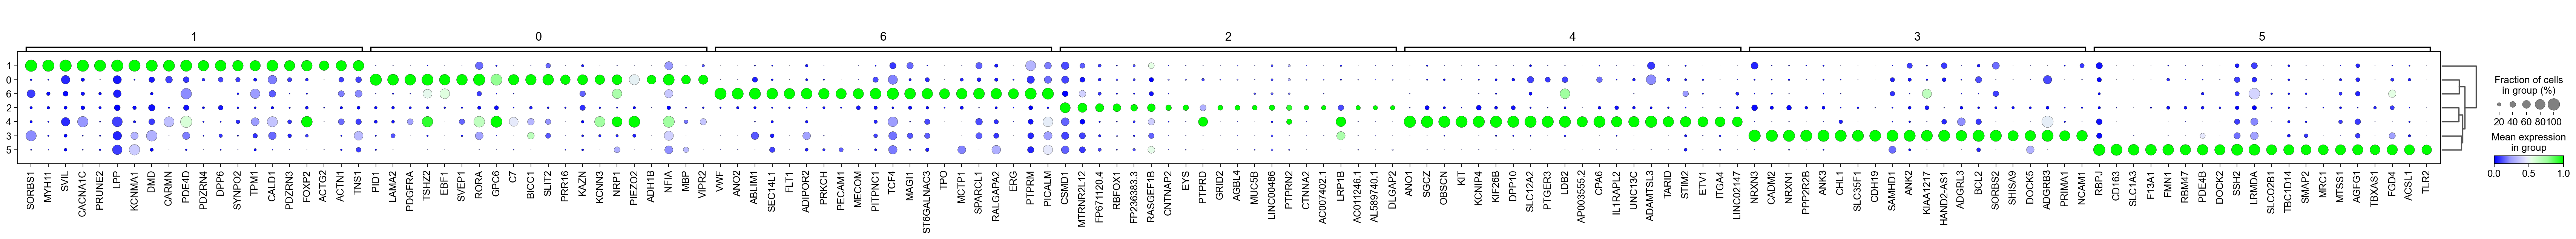

In [28]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=20, standard_scale='var', cmap=user_defined_cmap_degs)

## Create group annotation

In [29]:
# using exact match
adata.obs['cell_type'] = ['1.Fibroblasts (Stromal cells; subset 4)' if (x=='0') else 
                          '4.Endothelial cells (venous/VWF+)' if x=='6' else
                          '0.Macrophages (LYVE1+)' if x=='5' else
                          '3.Smooth muscle cells (PLPP2+)' if x=='1' else
                          '5.Enteric glial cells' if (x=='3') else 
                          '6.Goblet cells' if (x=='2') else '2.Interstitial cells of Cajal' if x=='4' else 'ERROR' for x in adata.obs['leiden_0.1']]

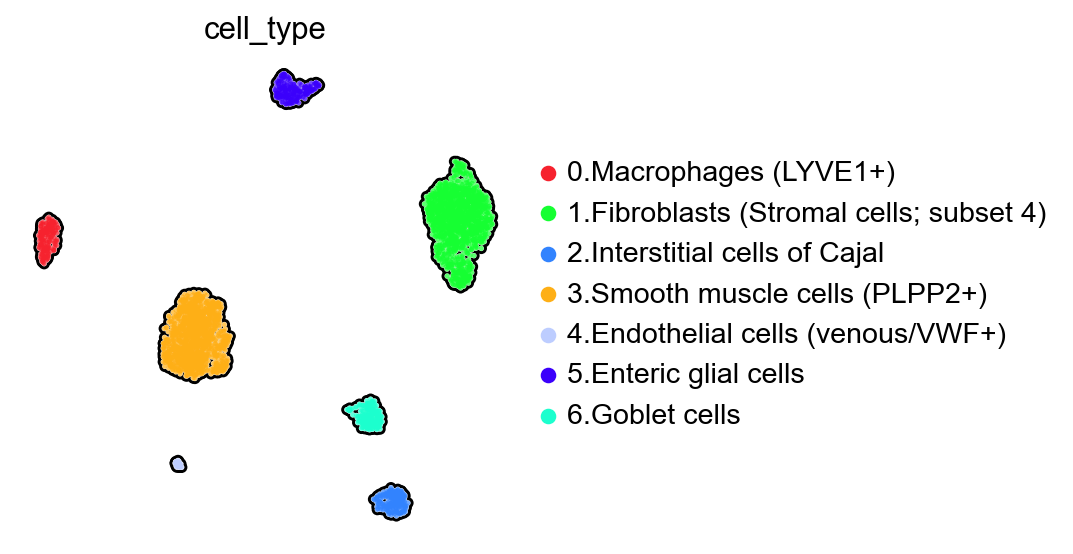

In [30]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=True, transparent=True)
sc.pl.umap(
    adata, 
    color=['cell_type'], 
    palette=user_defined_palette,  
    color_map='Spectral_r', 
    use_raw=False,
    ncols=4,
    wspace = 0.35,
    outline_width=[0.6, 0.05],
    size=20,
    frameon=False,
    add_outline=True,
    sort_order = False
)

In [31]:
marker_genes = ['CD163',  'LYVE1',  'RNASE1', 'PDGFRA', 'C7', 'KCNN3',   'KIT', 'ANO1', 'ETV1',  'MYH11', 'DES', 'CNN1', 'ACTA2', 
                'PECAM1', 'VWF',  'CDH19', 'CRYAB', 'SOX10', 'S100B',  'MUC5B', 'MUC4']

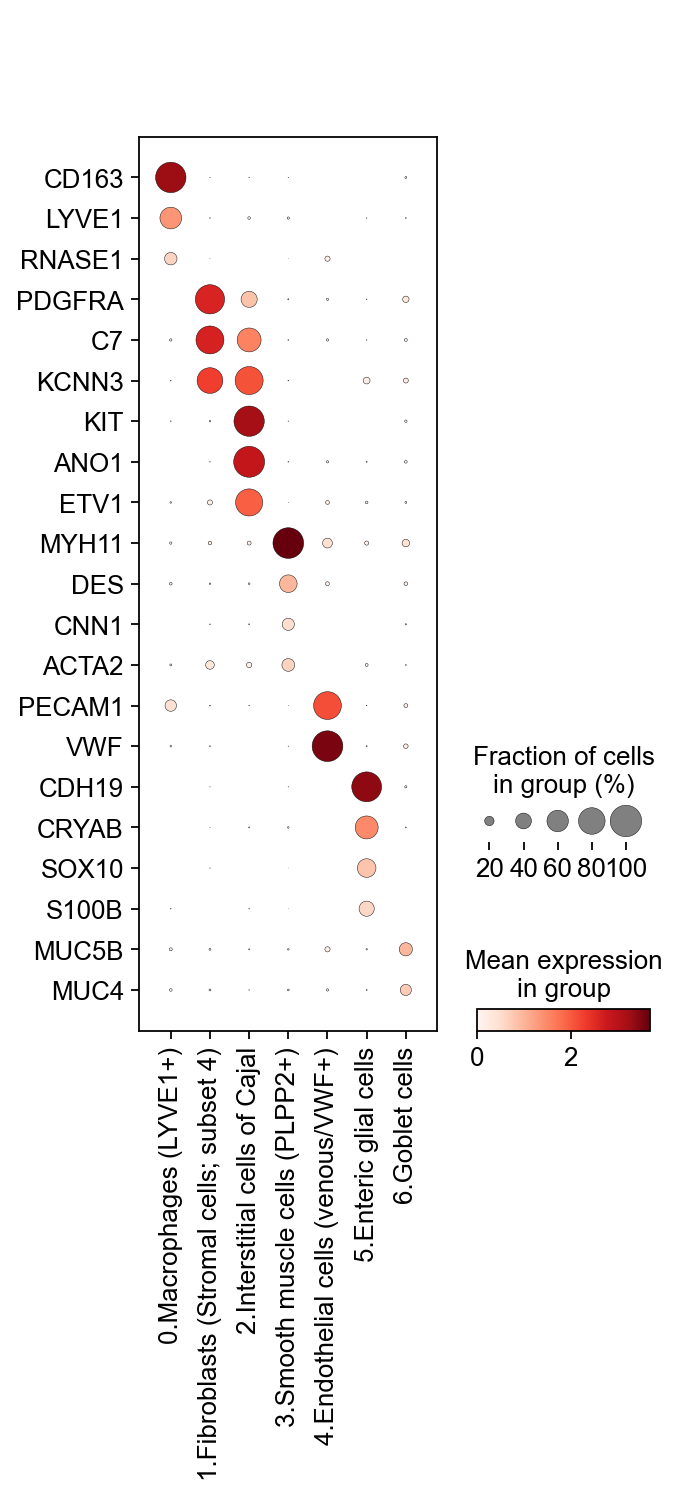

In [32]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=True, transparent=True)

sc.pl.dotplot(adata, marker_genes, 'cell_type', swap_axes=True, use_raw=False) 

### Stacked plots

In [33]:
# using exact match
adata.obs['patient'] = ['Patient_D' if (x=='Patient_D' or x=='Patient_D_2') else 
                        'Patient_F' if (x=='Patient_F' or x=='Patient_F_2') else 
                        'Patient_I' if (x=='Patient_I' or x=='Patient_I_2') else 
                        'ERROR' for x in adata.obs['sample']]

In [34]:
crosstb = pd.crosstab(adata.obs['patient'], adata.obs['cell_type'], normalize='index')

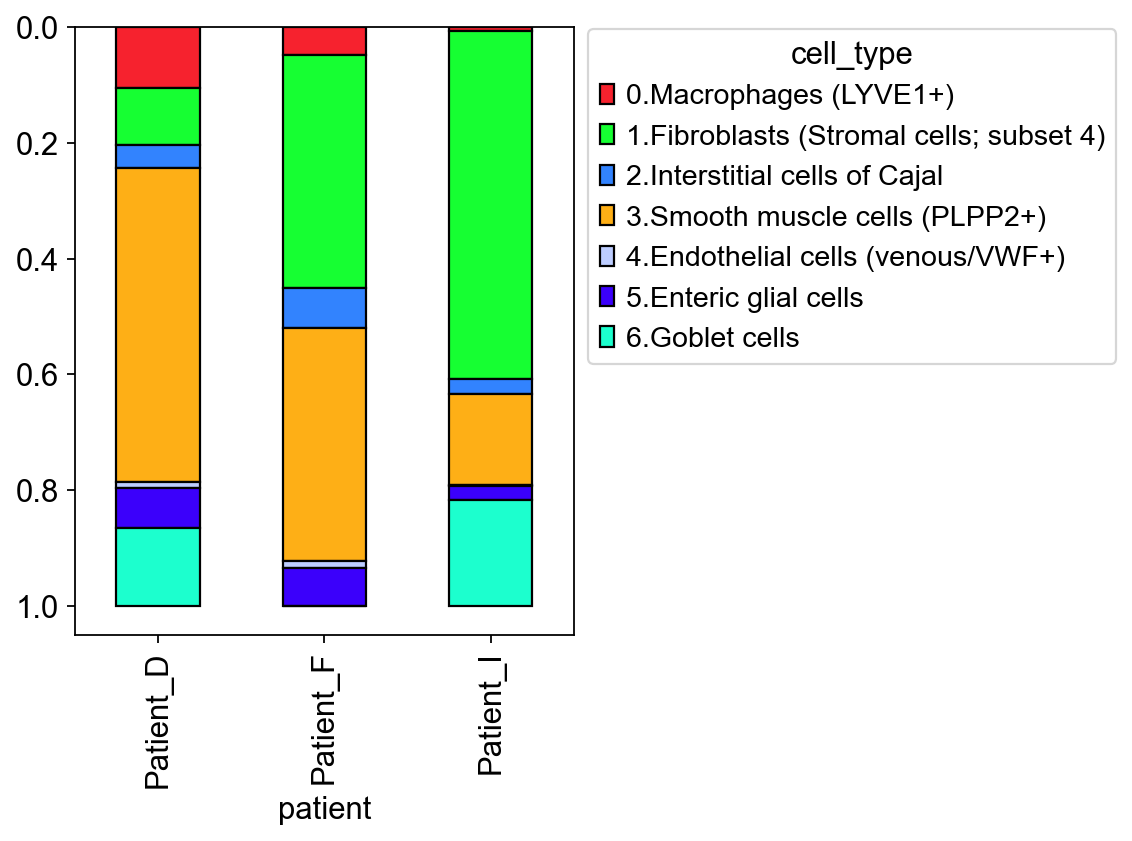

In [35]:
plt.rcParams['figure.figsize'] = [4, 5]

ax = crosstb.plot(kind='bar', stacked=True,  edgecolor = "black", color=adata.uns['cell_type_colors'])
ax.invert_yaxis()
ax.grid(False) 
ax.legend(title='cell_type', bbox_to_anchor=(1, 1.02), loc='upper left')

In [36]:
path_to_h5ad = '../output/metadata/anndata_objects/NucSeq.h5ad'

In [37]:
adata.write(path_to_h5ad)

In [5]:
adata = sc.read_h5ad(path_to_h5ad)
adata.uns['log1p']["base"] = None

In [38]:
adata.shape

(3437, 30861)

## Patient D

In [39]:
patient_D = adata[(adata.obs['sample']=='Patient_D') | (adata.obs['sample']=='Patient_D_2')]

In [40]:
patient_D.shape

(485, 30861)

In [41]:
Y_linked = ['AMELY',	'CDY1',	'CDY1B',	'CDY2A',	'CDY2B',	'NLGN4Y',	'PCDH11Y',	'PRORY',	'PRY',	'VCY',	'BPY2',	'BPY2B',	'BPY2C',	'PRY2',	'TMSB4Y',	'VCY1B',	'ZFY',	'DDX3Y',	'RPS4Y1',	'RPS4Y2',	'TBL1Y',	'TSPY1',	'TSPY2',	'TSPY3',	'TSPY4',	'TSPY8',	'TSPY9',	'TSPY10',	'USP9Y',	'EIF1AY',	'HSFY1',	'HSFY2',	'UTY',	'TGIF2LY',	'RBMY1A1',	'RBMY1B',	'RBMY1C',	'RBMY1D',	'RBMY1E',	'RBMY1F',	'RBMY1J',	'DHRSX',	'KDM5D']

sc.tl.score_genes(patient_D, gene_list=Y_linked, score_name='Y_linked_signature', use_raw=False)

computing score 'Y_linked_signature'
    finished: added
    'Y_linked_signature', score of gene set (adata.obs).
    299 total control genes are used. (0:00:00)


/Users/akousa/opt/anaconda3/envs/shunPykeR/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


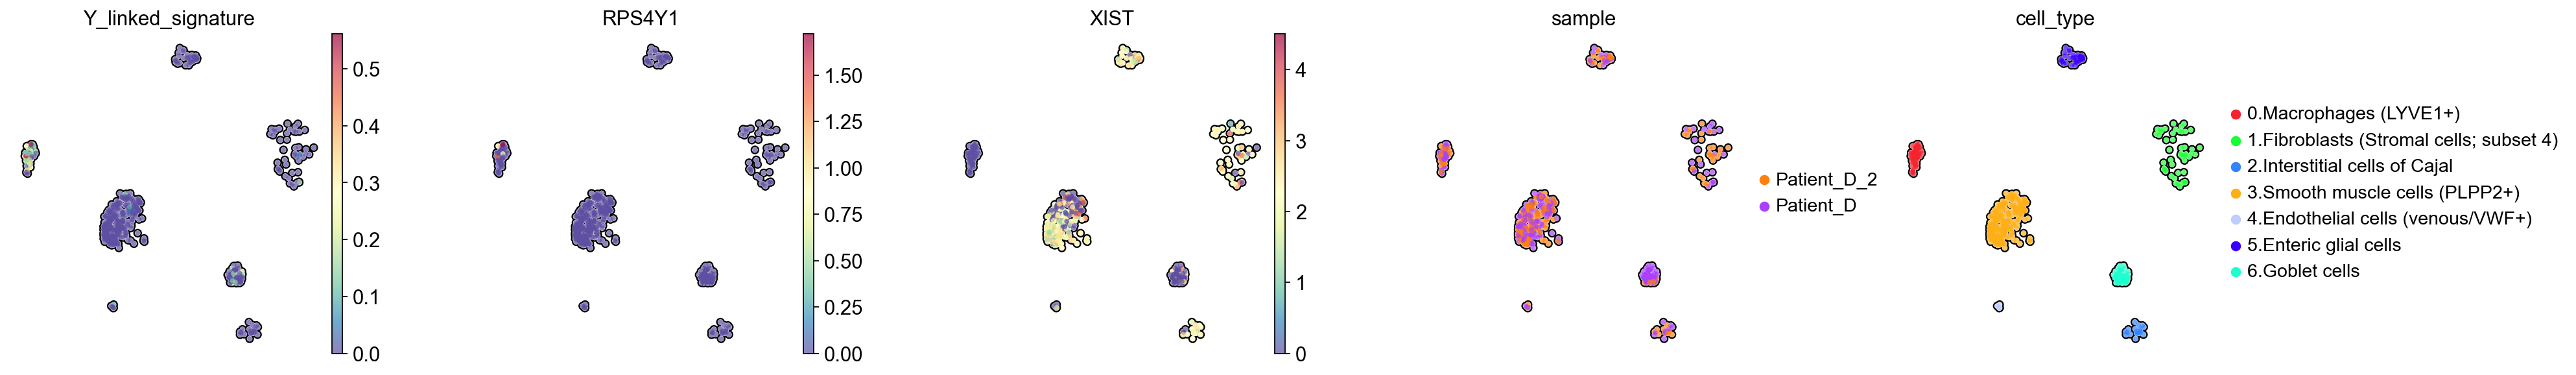

In [42]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=True, transparent=True)
sc.pl.umap(
    patient_D, 
    color=[ 'Y_linked_signature', 'RPS4Y1', 'XIST', 'sample', 'cell_type'], 
    color_map='Spectral_r', 
    use_raw=False,
    ncols=5,
    size=50,
    vmin=0,
    wspace = 0.35,
    frameon=False,
    add_outline=True,
    sort_order = False
)

In [43]:
patient_D[patient_D.obs['cell_type']=='0.Macrophages (LYVE1+)'].shape

(51, 30861)

## Patient I

In [44]:
patient_I = adata[(adata.obs['sample']=='Patient_I') | (adata.obs['sample']=='Patient_I_2')]

In [45]:
patient_I.shape

(779, 30861)

In [46]:
Y_linked = ['AMELY',	'CDY1',	'CDY1B',	'CDY2A',	'CDY2B',	'NLGN4Y',	'PCDH11Y',	'PRORY',	'PRY',	'VCY',	'BPY2',	'BPY2B',	'BPY2C',	'PRY2',	'TMSB4Y',	'VCY1B',	'ZFY',	'DDX3Y',	'RPS4Y1',	'RPS4Y2',	'TBL1Y',	'TSPY1',	'TSPY2',	'TSPY3',	'TSPY4',	'TSPY8',	'TSPY9',	'TSPY10',	'USP9Y',	'EIF1AY',	'HSFY1',	'HSFY2',	'UTY',	'TGIF2LY',	'RBMY1A1',	'RBMY1B',	'RBMY1C',	'RBMY1D',	'RBMY1E',	'RBMY1F',	'RBMY1J',	'DHRSX',	'KDM5D']

sc.tl.score_genes(patient_I, gene_list=Y_linked, score_name='Y_linked_signature', use_raw=False)

computing score 'Y_linked_signature'
    finished: added
    'Y_linked_signature', score of gene set (adata.obs).
    250 total control genes are used. (0:00:00)


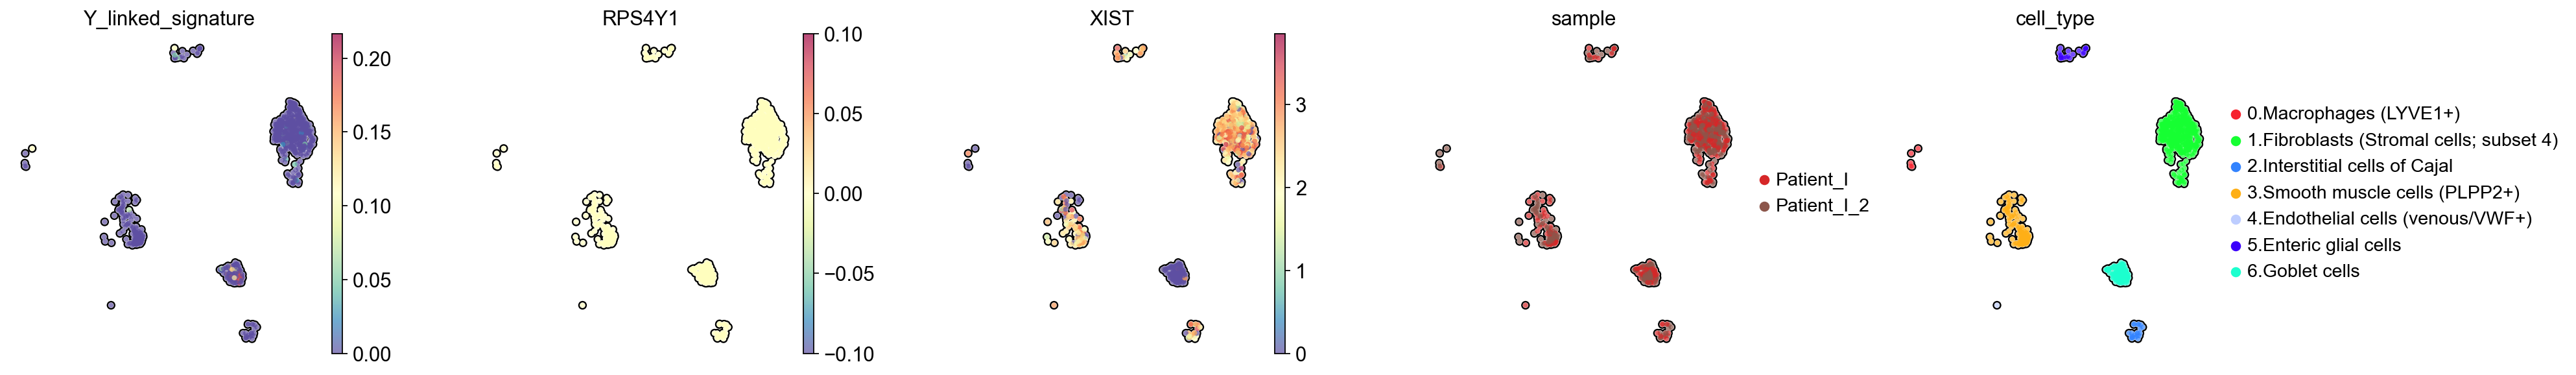

In [47]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=True, transparent=True)
sc.pl.umap(
    patient_I, 
    color=[ 'Y_linked_signature', 'RPS4Y1', 'XIST', 'sample', 'cell_type'], 
    color_map='Spectral_r', 
    use_raw=False,
    ncols=5,
    size=50,
    vmin=0,
    wspace = 0.35,
    frameon=False,
    add_outline=True,
    sort_order = False
)

In [48]:
patient_F = adata[(adata.obs['sample']=='Patient_F') | (adata.obs['sample']=='Patient_F_2')]

In [49]:
patient_F.shape

(2173, 30861)

In [50]:
Y_linked = ['AMELY',	'CDY1',	'CDY1B',	'CDY2A',	'CDY2B',	'NLGN4Y',	'PCDH11Y',	'PRORY',	'PRY',	'VCY',	'BPY2',	'BPY2B',	'BPY2C',	'PRY2',	'TMSB4Y',	'VCY1B',	'ZFY',	'DDX3Y',	'RPS4Y1',	'RPS4Y2',	'TBL1Y',	'TSPY1',	'TSPY2',	'TSPY3',	'TSPY4',	'TSPY8',	'TSPY9',	'TSPY10',	'USP9Y',	'EIF1AY',	'HSFY1',	'HSFY2',	'UTY',	'TGIF2LY',	'RBMY1A1',	'RBMY1B',	'RBMY1C',	'RBMY1D',	'RBMY1E',	'RBMY1F',	'RBMY1J',	'DHRSX',	'KDM5D']

sc.tl.score_genes(patient_F, gene_list=Y_linked, score_name='Y_linked_signature', use_raw=False)

computing score 'Y_linked_signature'
    finished: added
    'Y_linked_signature', score of gene set (adata.obs).
    450 total control genes are used. (0:00:00)


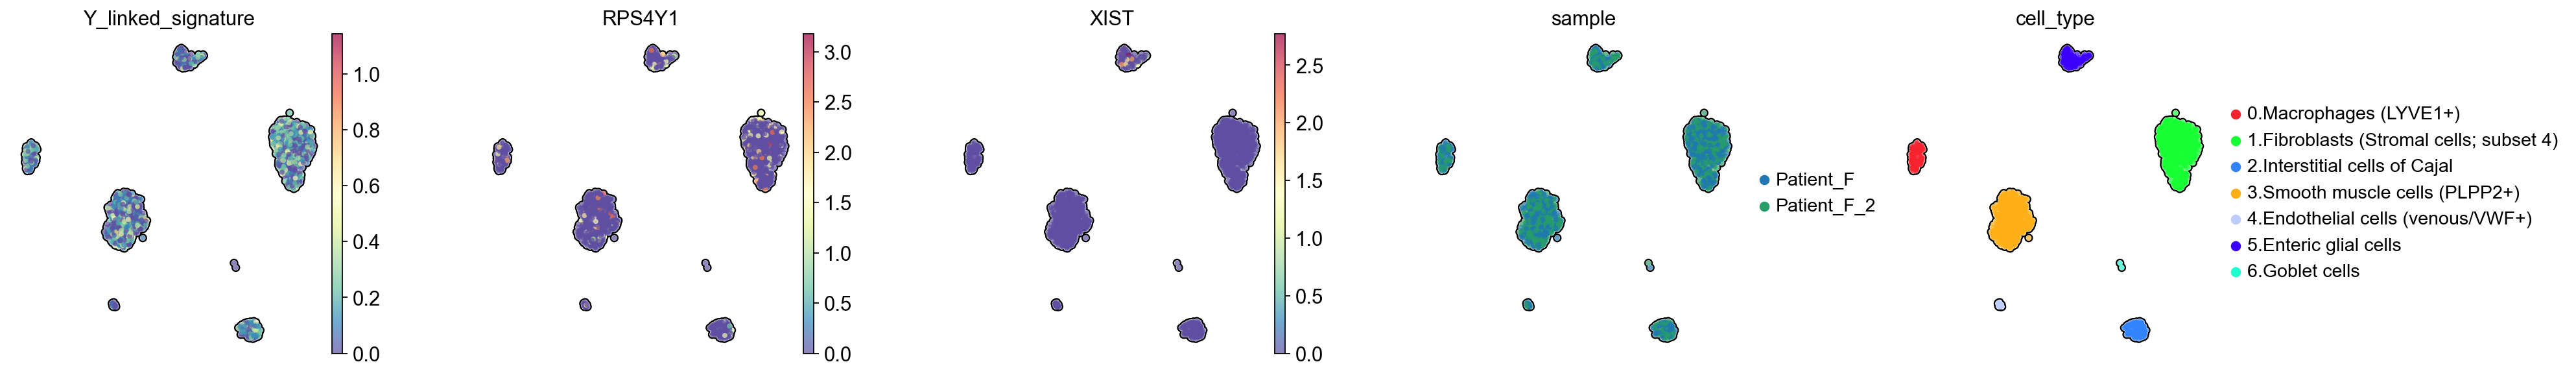

In [51]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=True, transparent=True)
sc.pl.umap(
    patient_F, 
    color=[ 'Y_linked_signature', 'RPS4Y1', 'XIST', 'sample', 'cell_type'], 
    color_map='Spectral_r', 
    use_raw=False,
    ncols=5,
    size=50,
    vmin=0,
    wspace = 0.35,
    frameon=False,
    add_outline=True,
    sort_order = False
)

In [52]:
patient_F[patient_F.obs['cell_type']=='5.Enteric glial cells'].shape

(140, 30861)

## XIST and RPS4Y1 expression per patient

In [53]:
adata.obs['distinct'] = ''
adata.obs['distinct'] = adata.obs[['patient', 'cell_type']].agg(' '.join, axis=1)

/Users/akousa/opt/anaconda3/envs/shunPykeR/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


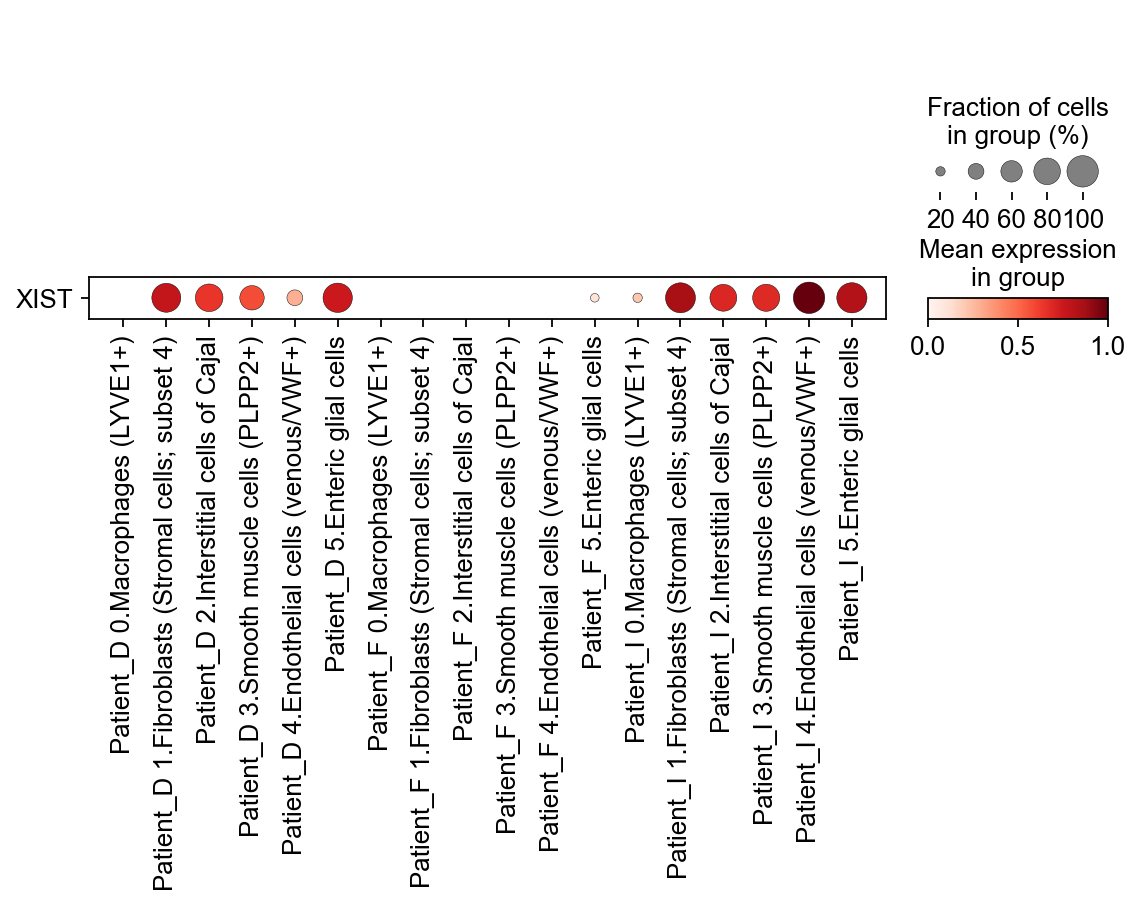

In [54]:
sc.pl.dotplot(adata[adata.obs['cell_type']!='6.Goblet cells'], ['XIST'], 'distinct', standard_scale='var', swap_axes=True, use_raw=False) 

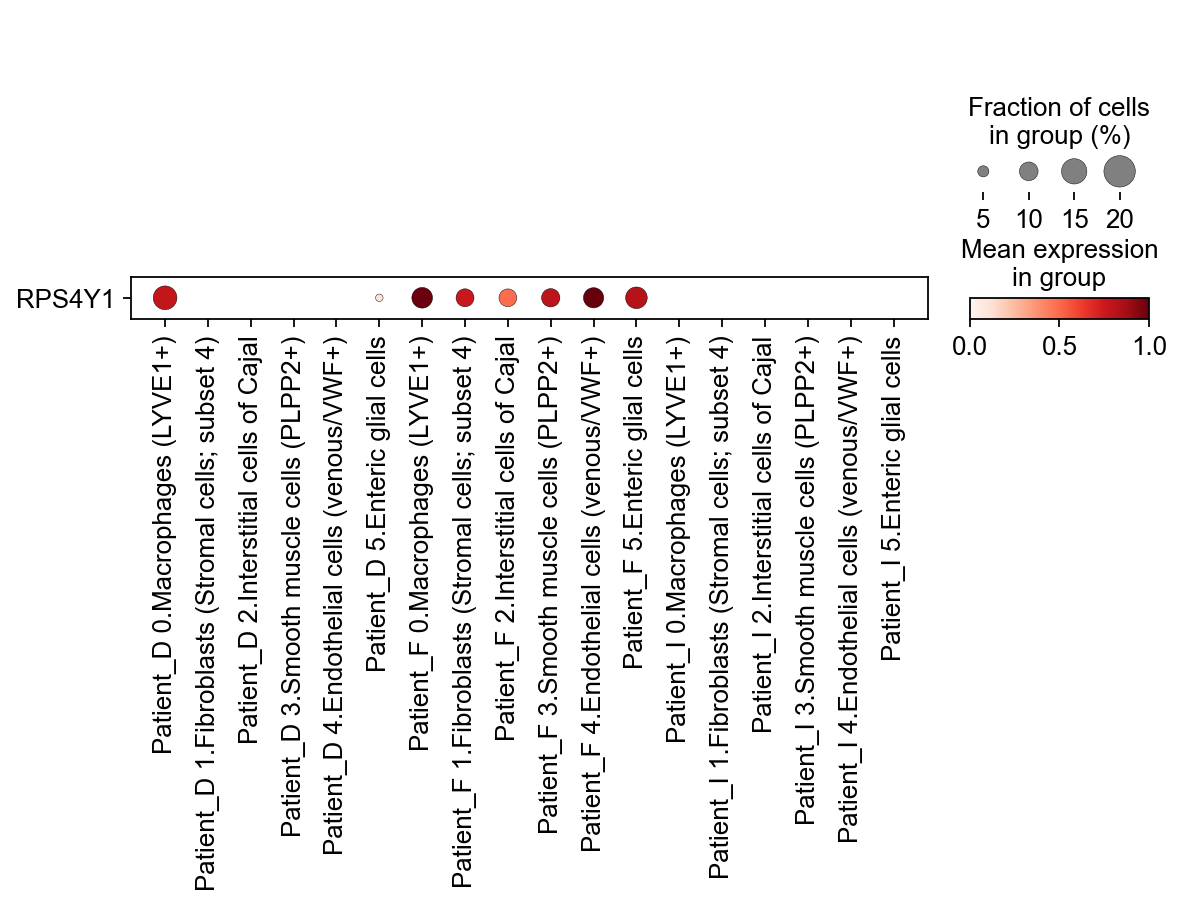

In [55]:
sc.pl.dotplot(adata[adata.obs['cell_type']!='6.Goblet cells'], ['RPS4Y1'], 'distinct', standard_scale='var', swap_axes=True, use_raw=False) 